# Data Preparation & Profiling

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Dibimbing/Data/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Dibimbing/Data/Kaggle


In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Data
colnames = ['ProductID','Product_type','Date','Price','Quantity']
df = pd.read_csv('ecom-elasticity-data1.csv', names=colnames, header=None)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462000 entries, 0 to 461999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ProductID     462000 non-null  object 
 1   Product_type  462000 non-null  object 
 2   Date          462000 non-null  object 
 3   Price         462000 non-null  float64
 4   Quantity      462000 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 17.6+ MB


In [5]:
df.head(10)

,ProductID,Product_type,Date,Price,Quantity
0,D9775,Diapers,2017-01-01,12.46,94
1,D80,Diapers,2017-01-01,11.56,102
2,D3248,Diapers,2017-01-01,12.21,93
3,D1714,Diapers,2017-01-01,11.54,75
4,D1408,Diapers,2017-01-01,13.16,94
5,D4564,Diapers,2017-01-01,13.09,86
6,D8861,Diapers,2017-01-01,11.83,85
7,D1053,Diapers,2017-01-01,10.75,117
8,D4231,Diapers,2017-01-01,12.53,80
9,D9387,Diapers,2017-01-01,10.92,82


# Exploratory Data Analysis

In [6]:
#Check values in different category_name
category = df['Product_type'].value_counts()
category

Cereals       220000
Headphones    132000
Diapers       110000
Name: Product_type, dtype: int64

In [7]:
#Select Cereals
df_feature = df[df['Product_type']=='Cereals']

#Make sure to not have any duplicates in the data
df_feature = df_feature.groupby(['Date','ProductID']).agg({'Price':'mean','Quantity': 'mean' }).reset_index()

#laptop data used for price elasticities
df_feature.head()

,Date,ProductID,Price,Quantity
0,2017-01-01,C1021,8.61,20
1,2017-01-01,C1023,12.96,128
2,2017-01-01,C1033,9.08,19
3,2017-01-01,C1037,8.56,19
4,2017-01-01,C1054,9.14,17


# Data Modelling

In [8]:
#Format and build a dataframe with x_values for each product within the category
x_pivot = df_feature.pivot( index='Date', columns='ProductID' ,values='Price' )
x_values = pd.DataFrame(x_pivot.to_records())
x_values.dropna()
print(x_values)

            Date  C1021  C1023  C1033  C1037  ...  C9865  C9880  C9904  C9976  C9982
0     2017-01-01   8.61  12.96   9.08   8.56  ...   8.88  13.25   9.29   9.49  10.33
1     2017-01-02   9.26  14.61  10.09   8.54  ...   9.30  14.80   8.35   9.93  12.53
2     2017-01-03   7.74  13.68   9.14   9.41  ...   9.08  14.35   8.85   9.16  12.21
3     2017-01-04   7.75  15.20   9.54   9.25  ...   8.88  16.19   9.26   9.51  10.06
4     2017-01-05   9.53  15.10   8.67   9.31  ...   9.22  16.01   8.69   9.91  10.30
...          ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
1095  2020-01-01   9.61  13.83   9.43   8.99  ...   8.51  14.52   9.16   8.71  12.03
1096  2020-01-02   9.36  14.10   8.87   8.46  ...   9.97  15.70   8.77   8.26  10.46
1097  2020-01-03   9.37  13.88   9.55   8.78  ...   8.97  14.66   9.22   8.40  10.36
1098  2020-01-04   8.12  16.03   8.98   9.14  ...   8.85  14.99   8.88   7.91  12.12
1099  2020-01-05   8.64  15.02   9.95   8.59  ...   8.68  14.03  

In [9]:
#Format and build a dataframe with y_values for each product within the category
y_pivot = df_feature.pivot( index='Date', columns='ProductID' ,values='Quantity' )
y_values = pd.DataFrame(y_pivot.to_records())
print(y_values)

            Date  C1021  C1023  C1033  C1037  ...  C9865  C9880  C9904  C9976  C9982
0     2017-01-01     20    128     19     19  ...     20    126     17     16     75
1     2017-01-02      6     50      4     10  ...      7     52     10      6     22
2     2017-01-03     11     57      7      6  ...      8     54      7      7     21
3     2017-01-04     11     52      6      6  ...      6     56      7      6     30
4     2017-01-05      6     46      9      7  ...      7     52      9      4     28
...          ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
1095  2020-01-01     11    102     12     13  ...     14     92     12     13     42
1096  2020-01-02     11     93     12     16  ...     10     82     15     15     44
1097  2020-01-03     13     95     11     14  ...     12     87     12     15     41
1098  2020-01-04     25    156     23     23  ...     26    152     25     34     78
1099  2020-01-05     26    161     19     24  ...     25    188  

In [10]:
points = []
results_values = {
    "ProductID": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["ProductID"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['ProductID','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]
df_elasticity

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ProductID,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept
0,C1021,-1.867437,-7.008212,4.205085e-12,-2.034992,8.992264,9.799091,28.098275
1,C1023,-0.610204,-2.940192,3.348807e-03,-2.772581,15.015018,68.223636,109.853996
2,C1033,-2.483998,-9.220659,1.466338e-19,-2.681333,9.014755,9.730909,33.902467
3,C1037,-1.759401,-6.736771,2.607991e-11,-1.904845,8.992945,9.736364,26.866530
4,C1054,-1.808118,-7.044223,3.285267e-12,-1.941935,9.016345,9.683636,27.192793
...,...,...,...,...,...,...,...,...
190,C9865,-2.188629,-7.848005,9.987339e-15,-2.374166,8.997273,9.760000,31.121020
191,C9880,-0.513903,-2.384022,1.729366e-02,-2.321705,15.020218,67.858182,102.730696
192,C9904,-1.912062,-6.971995,5.384050e-12,-2.066270,9.004682,9.730909,28.337010
193,C9976,-1.784719,-6.916666,7.836769e-12,-1.941549,8.983327,9.772727,27.214299


In [11]:
def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)

# Result

In [12]:
df_elasticity

,ProductID,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept
0,C1021,-1.867437,-7.008212,4.205085e-12,-2.034992,8.992264,9.799091,28.098275
1,C1023,-0.610204,-2.940192,3.348807e-03,-2.772581,15.015018,68.223636,109.853996
2,C1033,-2.483998,-9.220659,1.466338e-19,-2.681333,9.014755,9.730909,33.902467
3,C1037,-1.759401,-6.736771,2.607991e-11,-1.904845,8.992945,9.736364,26.866530
4,C1054,-1.808118,-7.044223,3.285267e-12,-1.941935,9.016345,9.683636,27.192793
...,...,...,...,...,...,...,...,...
190,C9865,-2.188629,-7.848005,9.987339e-15,-2.374166,8.997273,9.760000,31.121020
191,C9880,-0.513903,-2.384022,1.729366e-02,-2.321705,15.020218,67.858182,102.730696
192,C9904,-1.912062,-6.971995,5.384050e-12,-2.066270,9.004682,9.730909,28.337010
193,C9976,-1.784719,-6.916666,7.836769e-12,-1.941549,8.983327,9.772727,27.214299


In [13]:
df_sample = df_elasticity.head(10).append(df_elasticity.tail(10))
df_sample

,ProductID,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept
0,C1021,-1.867437,-7.008212,4.205085e-12,-2.034992,8.992264,9.799091,28.098275
1,C1023,-0.610204,-2.940192,3.348807e-03,-2.772581,15.015018,68.223636,109.853996
2,C1033,-2.483998,-9.220659,1.466338e-19,-2.681333,9.014755,9.730909,33.902467
3,C1037,-1.759401,-6.736771,2.607991e-11,-1.904845,8.992945,9.736364,26.866530
4,C1054,-1.808118,-7.044223,3.285267e-12,-1.941935,9.016345,9.683636,27.192793
5,C1075,-2.039594,-7.790449,1.540016e-14,-2.203727,8.985964,9.709091,29.511698
6,C1130,-2.142924,-8.142870,1.040509e-15,-2.331023,8.972427,9.760000,30.674937
7,C1178,-2.101505,-7.692258,3.203408e-14,-2.271697,9.009455,9.739091,30.205839
8,C1204,-0.855525,-5.589471,2.872244e-08,-2.636242,11.004618,33.910000,62.920837
9,C1268,-2.295698,-8.572717,3.388279e-17,-2.498088,8.985136,9.777273,32.222935


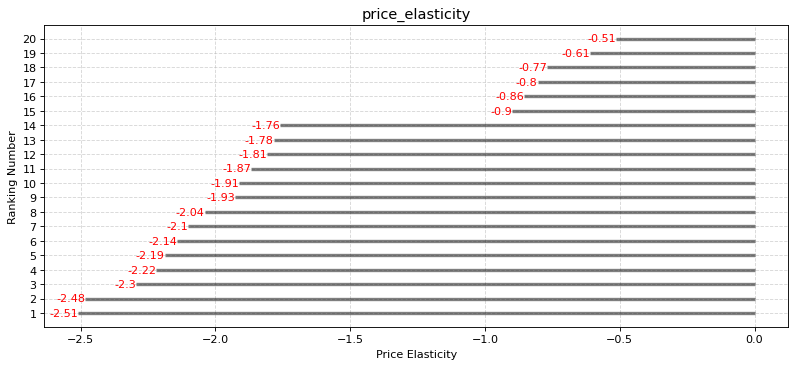

,ProductID,price_elasticity
ranking,,
20,C9880,-0.513903
19,C1023,-0.610204
18,C9811,-0.768930
17,C9838,-0.804992
16,C1204,-0.855525
15,C9982,-0.900030
14,C1037,-1.759401
13,C9976,-1.784719
12,C1054,-1.808118


In [14]:
pe_plot = divergent_plot(df_sample, 'price_elasticity', 'Ranking Number', 'Price Elasticity')

* Elasticities between 0- 1 are considered inelastic, as a result the products from rank 1 to 20 are elastic.
* Negative Price Elasticities are located from rank 1 to 20 and this would tell us the likelihood of when price decreases how likely sales demand would increase or vice versa.
* For instance, let’s analyze C1021 located in rank 11 with a negative price elasticity of -1.867437 ; a 10% price decrease in C1021, it increases sales demand by 18.67% or a 10% price increase in C1021, it decreases sales demand by 18.67%